## Вариант 1

In [5]:
sales_train = pd.read_csv('sales_train.csv')
items_data = pd.read_csv('items.csv')
item_categories_data = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [18]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,day,date_delta
0,2013-01-02,0,59,22154,999.00,1.0,1,2013,2013-01-02,1.0
1,2013-01-03,0,25,2552,899.00,1.0,1,2013,2013-01-03,2.0
3,2013-01-06,0,25,2554,1709.05,1.0,1,2013,2013-01-06,5.0
4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,2013-01-15,14.0
5,2013-01-10,0,25,2564,349.00,1.0,1,2013,2013-01-10,9.0
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,10,2015,2015-10-10,1012.0
2935845,2015-10-09,33,25,7460,299.00,1.0,10,2015,2015-10-09,1011.0
2935846,2015-10-14,33,25,7459,349.00,1.0,10,2015,2015-10-14,1016.0
2935847,2015-10-22,33,25,7440,299.00,1.0,10,2015,2015-10-22,1024.0


In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sales_train['date'] = pd.to_datetime(sales_train['date'], dayfirst=True)
sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year


sales_train = sales_train[sales_train['item_cnt_day'] > 0]

features = sales_train[['date_block_num', 'shop_id', 'item_id', 'item_price', 'month', 'year']]
target = sales_train['item_cnt_day']

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

X_train, X_val, y_train, y_val = train_test_split(features_normalized, target, test_size=0.2, random_state=42)


class SalesDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, pd.DataFrame) or isinstance(features, pd.Series):
            features = features.values
        if isinstance(labels, pd.Series):
            labels = labels.values
        
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.float)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = SalesDataset(X_train, y_train)
val_dataset = SalesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 50) 
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = SimpleNet(input_size=6) 

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 9
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_features)
        loss = criterion(output.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            output = model(batch_features)
            loss = criterion(output.squeeze(), batch_labels)
            val_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')


Epoch 1, Train Loss: 7.1337, Validation Loss: 4.9528
Epoch 2, Train Loss: 7.0171, Validation Loss: 4.9408
Epoch 3, Train Loss: 6.9698, Validation Loss: 4.8675
Epoch 4, Train Loss: 6.9476, Validation Loss: 4.8753
Epoch 5, Train Loss: 6.9412, Validation Loss: 4.8732
Epoch 6, Train Loss: 6.9326, Validation Loss: 4.8537
Epoch 7, Train Loss: 6.9246, Validation Loss: 4.8476
Epoch 8, Train Loss: 6.9169, Validation Loss: 4.9029
Epoch 9, Train Loss: 6.9060, Validation Loss: 4.8126


Epoch 1, Train Loss: 6.9283, Validation Loss: 4.8361
Epoch 2, Train Loss: 6.9193, Validation Loss: 4.8259
Epoch 3, Train Loss: 6.9085, Validation Loss: 4.8433
Epoch 4, Train Loss: 6.8992, Validation Loss: 4.8555
Epoch 5, Train Loss: 6.9109, Validation Loss: 4.8348
Epoch 6, Train Loss: 6.9059, Validation Loss: 4.8286
Epoch 7, Train Loss: 6.8902, Validation Loss: 4.8004
Epoch 8, Train Loss: 6.8834, Validation Loss: 4.8121
Epoch 9, Train Loss: 6.8676, Validation Loss: 4.8085


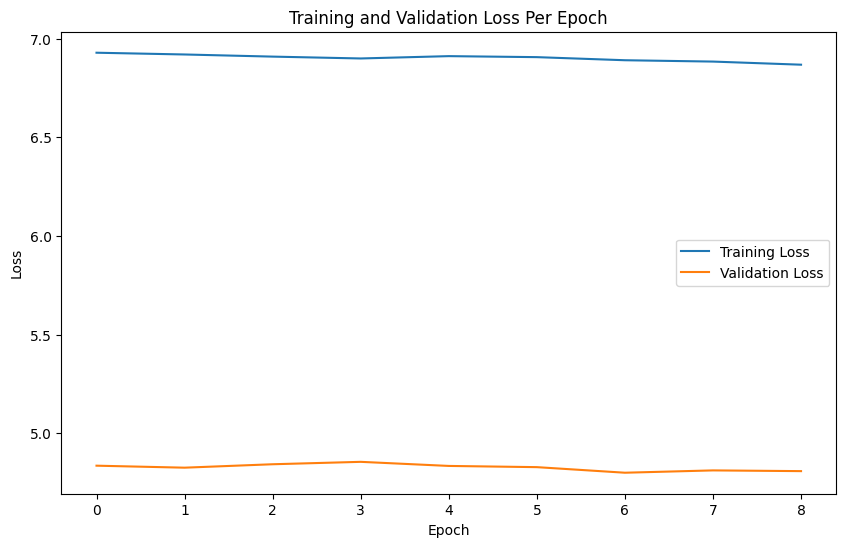

In [8]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

epochs = 9 

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_features)
        loss = criterion(output.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            output = model(batch_features)
            loss = criterion(output.squeeze(), batch_labels)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


model.eval()  

true_labels = []
predictions = []

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        outputs = model(batch_features)
        predictions.extend(outputs.view(-1).tolist())  
        true_labels.extend(batch_labels.tolist())


predictions = np.array(predictions)
true_labels = np.array(true_labels)


mse = mean_squared_error(true_labels, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predictions)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')


RMSE: 2.2080
MAE: 0.3821
MSE: 4.8754


## Вариант 2

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Предполагаем, что sales_train - это ваш DataFrame
# Выбираем признаки и целевую переменную
features = sales_train[['date_block_num', 'shop_id', 'item_id', 'item_price', 'month', 'year']]
target = sales_train['item_cnt_day']

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_data, batch_size=64)

import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNet(input_size=6)  # 6 признаков

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    r2 = r2_score(y_test_tensor.numpy(), predictions.numpy())
    print(f'R^2 Score: {r2:.4f}')



Epoch 1/5, Loss: 0.2210
Epoch 2/5, Loss: 0.0305
Epoch 3/5, Loss: 0.0968
Epoch 4/5, Loss: 0.4102
Epoch 5/5, Loss: 0.0513
R^2 Score: 0.0516
